# Predicting Age From X-Rays

# Goal
Develop an algorithm to determine the age of a child by utilizing x-rays of hands (pediatric hand radiographs).

In [1]:
# Common variables for all models
batchSize = 20
epochs = 2

## Expore the dataset

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 

# CSV file contains the id, age, and gender related to each x-ray
dataset = pd.read_csv("Input/boneage-dataset.csv")

# Dropping all rows with any NA values
dataset.dropna()

print('There are %d total data samples.' % dataset.shape[0])
print('\nData type for each column is:\n',dataset.dtypes)
dataset.head()

There are 12611 total data samples.

Data type for each column is:
 id         int64
boneage    int64
male        bool
dtype: object


,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


Max, mean, and standard deviation of bone age is 228, 127.32, and 41.18 months, respectively.
Total number of male and female is 6833 (54.18%) and 5778 (45.82%), respectively.


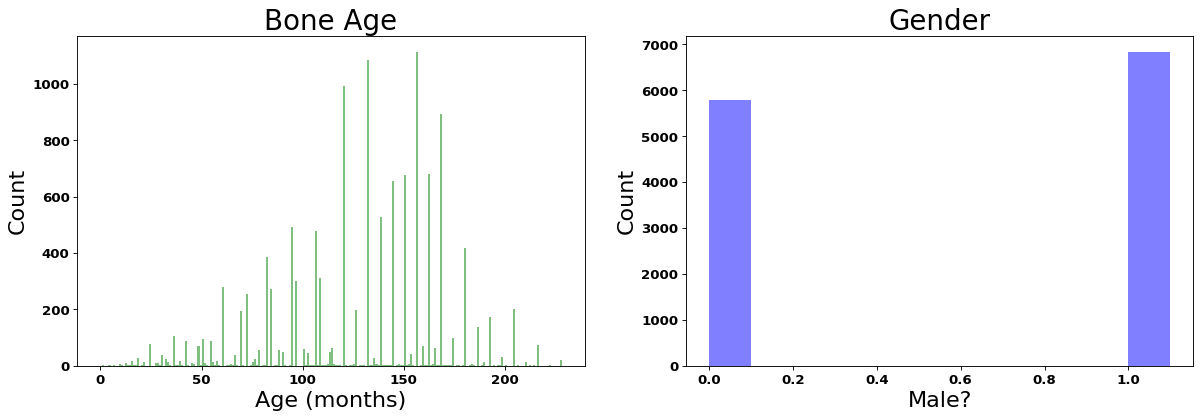

In [3]:
# Plot the total distribution for boneage and gender
import PlottingTools as pt

myFigure = plt.figure(figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k') 
myAxis1 = myFigure.add_subplot(2,2,1)
myAxis2 = myFigure.add_subplot(2,2,2)

myAxis1.hist(dataset['boneage'], 228, range = (0, 228.0), color='g', alpha=0.5)
myAxis2.hist(dataset['male'], 11, range = (0, 1.1), color='b', alpha=0.5)

#Title and stuff
pt.setTitle(myAxis1, 'Bone Age', 'Age (months)', 'Count')
pt.setTitle(myAxis2, 'Gender', 'Male?', 'Count')

#Ticks
pt.setTicks(myAxis1)
pt.setTicks(myAxis2)

myFigure.savefig('Plots/RawDistribution.pdf')

print('Max, mean, and standard deviation of bone age is %d, %.2f, and %.2f months, respectively.' 
      %(dataset['boneage'].max(), dataset['boneage'].mean(), dataset['boneage'].std()))
print('Total number of male and female is %d (%.2f%%) and %d (%.2f%%), respectively.' 
      %(dataset[dataset['male']==1].shape[0], 
        dataset[dataset['male']==1].shape[0]*100/dataset.shape[0],
        dataset[dataset['male']==0].shape[0], 
        dataset[dataset['male']==0].shape[0]*100/dataset.shape[0]))

### Connect the x-ray images to the dataset

In [4]:
import os

dataset['image_path'] = dataset['id'].map(lambda x: os.path.join('Input/boneage-dataset', '{}.png'.format(x)))

if dataset['image_path'].map(os.path.exists).sum() != dataset.shape[0]:
    print('Warning!! Only', dataset['image_path'].map(os.path.exists).sum(), 
          'x-ray images found out of', dataset.shape[0], 'total! \nWill continue with reduced dataset!!')
    dataset = dataset[dataset['image_path'].map(os.path.exists)]
else:
    print('Awesome!! All',dataset['image_path'].map(os.path.exists).sum(), 
          'x-ray images found out of', dataset.shape[0], 'total!')

Awesome!! All 12611 x-ray images found out of 12611 total!


### Perform data cleaning

In [5]:
# Make new colum 'boneage_category' such that each category has the same number of samples
deciles_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
deciles = dataset['boneage'].quantile(q=deciles_list)

deciles_labels =[]
for i in range(deciles.size):
    if i==deciles.size-1: continue
    deciles_labels.append(str(deciles[deciles.index[i]])+'-'+str(deciles[deciles.index[i+1]]))   
print(deciles_labels, '\n')
    
dataset['boneage_category'] = pd.qcut(dataset['boneage'], q=deciles_list, labels=deciles_labels)
print(dataset.head())

['1.0-69.0', '69.0-94.0', '94.0-106.0', '106.0-120.0', '120.0-132.0', '132.0-144.0', '144.0-156.0', '156.0-162.0', '162.0-168.0', '168.0-228.0'] 

     id  boneage   male                      image_path boneage_category
0  1377      180  False  Input/boneage-dataset/1377.png      168.0-228.0
1  1378       12  False  Input/boneage-dataset/1378.png         1.0-69.0
2  1379       94  False  Input/boneage-dataset/1379.png        69.0-94.0
3  1380      120   True  Input/boneage-dataset/1380.png      106.0-120.0
4  1381       82  False  Input/boneage-dataset/1381.png        69.0-94.0


### Tools to preprocess the images for Keras

In [6]:
# Take a string-valued image path and returns 4D tensor

from keras.preprocessing import image                  
from tqdm import tqdm
import cv2

def grayscaleImageToTensor(imageToConvert):
    # Load the image as grayscale; wxh=200x200
    img = image.load_img(imageToConvert, grayscale=True, target_size=(200, 200))
    
    # Convert a PIL Image instance to a Numpy array with shape (200, 200, 1)
    x = image.img_to_array(img)
    
    # Convert 3D tensor to 4D tensor with shape (1, 200, 200, 1) and return 4D tensor
    return np.expand_dims(x, axis=0)

def grayscaleImagesToTensor(imagesToConvert):
    listOfTensors = [grayscaleImageToTensor(imageToConvert) for imageToConvert in tqdm(imagesToConvert)]
    return np.vstack(listOfTensors)

def rgbImageToTensor(imageToConvert):
    # Load the RGB images as PIL.Image.Image type; wxh=200x200
    img = image.load_img(imageToConvert, target_size=(200, 200))
    
    # Convert a PIL Image instance to a Numpy array with shape (200, 200, 3); return 3D tensor
    x = image.img_to_array(img)
    
    # Convert 3D tensor to 4D tensor with shape (1, 200, 200, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def rgbImagesToTensor(imagesToConvert):
    listOfTensors = [rgbImageToTensor(imageToConvert) for imageToConvert in tqdm(imagesToConvert)]
    return np.vstack(listOfTensors)

Using TensorFlow backend.


# Benchmark model from scratch

In [7]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True          

# Convert every x-ray images to 4D tensors
X = grayscaleImagesToTensor(dataset['image_path'])

# Rescale the images by dividing every pixel in every image by 255
# rescale [0,255] --> [0,1]
X = X.astype('float32')/255

100%|██████████| 12611/12611 [05:52<00:00, 35.79it/s]


In [8]:
from keras.utils import np_utils

# One-hot encode the labels
# Bone age in the sample is from 0 to 228 months
y = dataset['boneage']
y = np_utils.to_categorical(y, 229)

print('One-hot labels:')
print(y[:5])

One-hot labels:
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


### Split data into training, testing, and validation sets

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=99, 
                                                    stratify=dataset['boneage_category'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=99)
                                                                    
print("The dataset has a training set of %d examples." % len(X_train))
print("The dataset has a test set of %d examples." % len(X_test))
print("The dataset has a validation set of %d examples." % len(X_val))

The dataset has a training set of 7093 examples.
The dataset has a test set of 3153 examples.
The dataset has a validation set of 2365 examples.


In [ ]:
#Visualize a single training image in detail

def visualizeImage(img, ax):
    ax.imshow(np.squeeze(img), cmap='gray')
    width, height, depth = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y][0],1)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y][0]<thresh else 'black')
            
fig = plt.figure(figsize = (75,75)) 
ax = fig.add_subplot(111)
visualizeImage(X_train[0], ax)

fig.savefig('Plots/SingleTrainingImage.pdf')

### Create and configure augmented image generator

In [10]:
from keras.preprocessing.image import ImageDataGenerator

# Generate batches of tensor image data with real-time data augmentation
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,    # Fraction of total width for random horizontal shifts
    height_shift_range=0.1,   # Fraction of total height for random vertical shifts
    rotation_range = 5,        # Degree range for random rotations
    horizontal_flip=True)      # Randomly flip images horizontally

# Fit augmented image generator on data
datagen_train.fit(X_train)

### Visualize original and augmented images

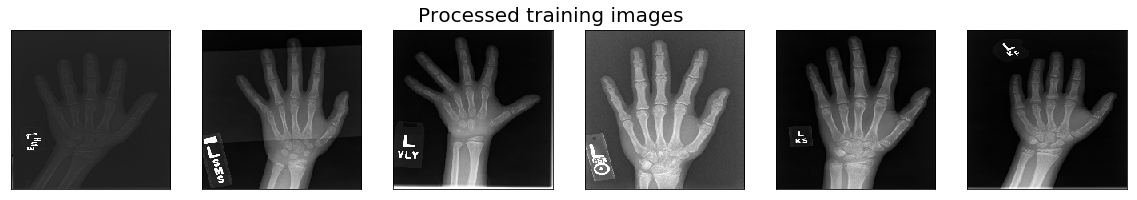

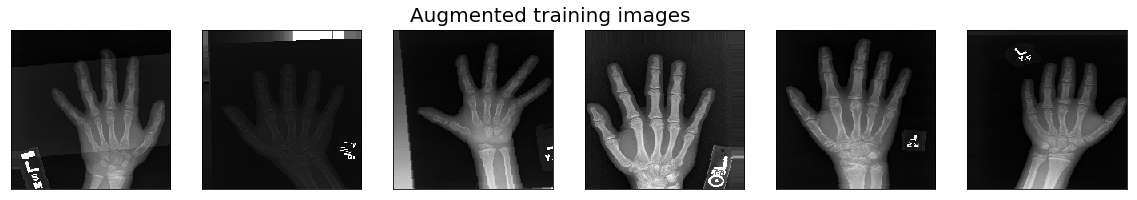

In [11]:
# Visualize the first six original and augmented training images
X_train_subset = X_train[:6]

fig = plt.figure(figsize=(20,3))
for i in range(0, len(X_train_subset)):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train_subset[i]), cmap='gray')
fig.suptitle('Processed training images', fontsize=20)
plt.show()
fig.savefig('Plots/ProcessedTrainingImages.pdf')

fig = plt.figure(figsize=(20,3))
for X_batch in datagen_train.flow(X_train_subset, batch_size=6):
    for i in range(6):
        ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_batch[i]), cmap='gray')
    # Need to break the loop because the generator loops indefinitely
    break 
fig.suptitle('Augmented training images', fontsize=20)
plt.show()
fig.savefig('Plots/AugmentedTrainingImages.pdf')

### Define the benchmark model architecture

In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

benchmarkModel = Sequential()

benchmarkModel.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu',input_shape=X_train[0].shape))
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.5))

benchmarkModel.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.5))

benchmarkModel.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.5))

benchmarkModel.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.5))

benchmarkModel.add(Flatten())         
benchmarkModel.add(Dense(500, activation='relu'))
benchmarkModel.add(Dropout(0.5))

benchmarkModel.add(Dense(229, activation='softmax'))

benchmarkModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 16)      80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        8256      
__________

### Compile the code

In [13]:
benchmarkModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Calculate the classification accuracy of the benchmark model (before training)

In [14]:
# Evaluate the test accuracy
score = benchmarkModel.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the benchmark model (before training): %.4f%%' % accuracy)

Test accuracy of the benchmark model (before training): 0.0634%


### Train the benchmark model

Epoch 00000: val_loss improved from inf to 3.72363, saving model to SavedModels/BenchmarkBest.hdf5
Epoch 00001: val_loss improved from 3.72363 to 3.52471, saving model to SavedModels/BenchmarkBest.hdf5
dict_keys(['val_acc', 'loss', 'lr', 'val_loss', 'acc'])


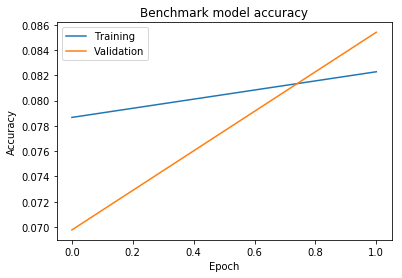

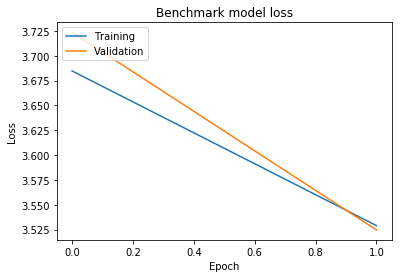

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau    

# Save the best model after every epoch
checkPoint = ModelCheckpoint(filepath='SavedModels/BenchmarkBest.hdf5', save_best_only=True, verbose=1)

# Stop training when a monitored quantity has stopped improving after 20 epochs
earlyStop = EarlyStopping(patience=20, verbose=1)

# Reduce learning rate when a metric has stopped improving
reduceLR = ReduceLROnPlateau(factor=0.3, patience=3, cooldown=3, min_lr=0.0001, verbose=1)

# Fit the model on batches with real-time data augmentation:
history = benchmarkModel.fit_generator(datagen_train.flow(X_train, y_train, batch_size=batchSize),
                                       steps_per_epoch=X_train.shape[0] // batchSize, epochs=epochs, 
                                       validation_data=(X_val, y_val), validation_steps=X_val.shape[0] // batchSize,
                                       callbacks=[checkPoint, earlyStop, reduceLR], verbose=0)
# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Benchmark model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/BenchmarkAccuracy.pdf')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Benchmark model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/BenchmarkLoss.pdf')
plt.show()

### Calculate the classification accuracy of the benchmark model (after training)

In [16]:
# Load the model with the best classification accuracy on the validation set
benchmarkModel.load_weights('SavedModels/BenchmarkBest.hdf5')

# Calculate the classification accuracy on the test set
score = benchmarkModel.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the benchmark model (after training): %.4f%%' % accuracy)

Test accuracy of the benchmark model (after training): 8.3730%


### Visualize the result of the benchmark model 

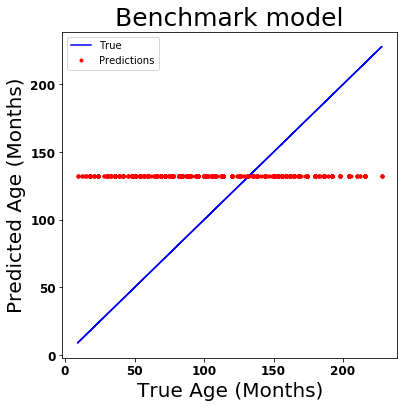

In [17]:
y_pred = benchmarkModel.predict(X_test, verbose = False)

y_p = []
for y in y_pred:
    y_p.append(np.argmax(y))
y_t = []
for t in y_test:
    y_t.append(np.argmax(t))

fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(y_t, y_t, 'b-', label = 'True')
ax1.plot(y_t, y_p, 'r.', label = 'Predictions')
ax1.legend()
ax1.set_title('Benchmark model', fontsize=25)
ax1.set_xlabel('True Age (Months)', fontsize=20)
ax1.set_ylabel('Predicted Age (Months)', fontsize=20)
pt.setTicks(ax1)

fig.savefig('Plots/BenchmarkResult.pdf')

# Model based on VGG16 bottleneck features

### Reprocess the raw images

In [18]:
# Convert every x-ray images to 4D tensors
X_new = rgbImagesToTensor(dataset['image_path'])

# Rescale the images by dividing every pixel in every image by 255
# rescale [0,255] --> [0,1]
X_new = X_new.astype('float32')/255

# One-hot encode the labels
# Bone age in the sample is from 0 to 228 months
y_new = dataset['boneage']
y_new = np_utils.to_categorical(y_new, 229)

print('One-hot labels:')
print(y_new[:5])

100%|██████████| 12611/12611 [06:07<00:00, 34.35it/s]


One-hot labels:
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


### Split data into training and testing sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.25, random_state=99,
                                                   stratify=dataset['boneage_category'])
print("The dataset has a training set of %d examples." % len(X_train))
print("The dataset has a test set of %d examples." % len(X_test))

The dataset has a training set of 9458 examples.
The dataset has a test set of 3153 examples.


### Extract bottleneck features for training and testing dataset

In [21]:
from keras.applications.vgg16 import VGG16, preprocess_input

# Load VGG16 model + remove final classification layers
model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Extract the training bottleneck features
features_train = model.predict(preprocess_input(X_train))

# Extract the testing bottleneck features
features_test = model.predict(preprocess_input(X_test))

### Define the bottleneck network architecture

In [22]:
VGG16BottleneckModel = Sequential()

VGG16BottleneckModel.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu',
                                input_shape=features_train[0].shape))
VGG16BottleneckModel.add(Dropout(0.5))

VGG16BottleneckModel.add(GlobalAveragePooling2D())         
VGG16BottleneckModel.add(Dropout(0.5))
VGG16BottleneckModel.add(Dense(229, activation='softmax'))

VGG16BottleneckModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 6, 6, 16)          32784     
_________________________________________________________________
dropout_6 (Dropout)          (None, 6, 6, 16)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 229)               3893      
Total params: 36,677
Trainable params: 36,677
Non-trainable params: 0
_________________________________________________________________


### Compile the code

In [23]:
VGG16BottleneckModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Calculate the classification accuracy of the VGG16 bottleneck model (before training)

In [24]:
# Evaluate the test accuracy
score = VGG16BottleneckModel.evaluate(features_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the VGG16 bottleneck model (before training): %.4f%%' % accuracy)

Test accuracy of the VGG16 bottleneck model (before training): 0.0000%


### Train the model

Epoch 00000: val_loss improved from inf to 3.49263, saving model to SavedModels/VGG16BottleneckBest.hdf5
Epoch 00001: val_loss improved from 3.49263 to 3.48846, saving model to SavedModels/VGG16BottleneckBest.hdf5
dict_keys(['val_acc', 'loss', 'lr', 'val_loss', 'acc'])


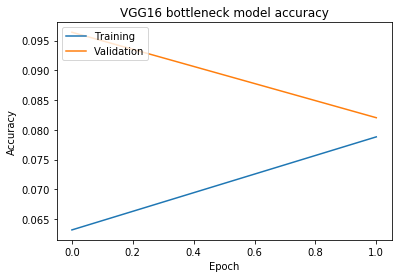

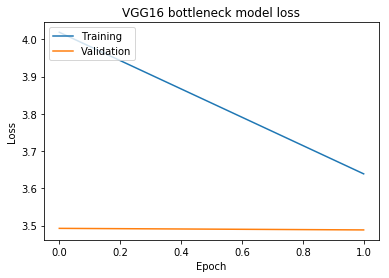

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau    

# Save the best model after every epoch
checkPoint = ModelCheckpoint(filepath='SavedModels/VGG16BottleneckBest.hdf5', save_best_only=True, verbose=1)

# Fit the model on batches with real-time data augmentation:
history= VGG16BottleneckModel.fit(features_train, y_train, batch_size=batchSize, epochs=epochs,
                                  validation_split=0.25, callbacks=[checkPoint, earlyStop, reduceLR],
                                  shuffle=True, verbose=0)

# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('VGG16 bottleneck model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/VGG16BottleneckAccuracy.pdf')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 bottleneck model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/VGG16BottleneckLoss.pdf')
plt.show()

### Calculate the classification accuracy of the VGG16 bottleneck model (after training)

In [26]:
# Load the model with the best classification accuracy on the validation set
VGG16BottleneckModel.load_weights('SavedModels/VGG16BottleneckBest.hdf5')

# Calculate the classification accuracy on the test set
score = VGG16BottleneckModel.evaluate(features_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the VGG16Bottleneck model (after training): %.4f%%' % accuracy)

Test accuracy of the VGG16Bottleneck model (after training): 7.6118%


### Visualize the result of the model 

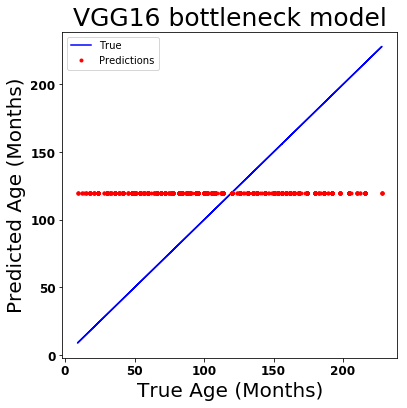

In [27]:
y_pred = VGG16BottleneckModel.predict(features_test, verbose = False)

y_p = []
for y in y_pred:
    y_p.append(np.argmax(y))
y_t = []
for t in y_test:
    y_t.append(np.argmax(t))

fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(y_t, y_t, 'b-', label = 'True')
ax1.plot(y_t, y_p, 'r.', label = 'Predictions')
ax1.legend()
ax1.set_title('VGG16 bottleneck model', fontsize=25)
ax1.set_xlabel('True Age (Months)', fontsize=20)
ax1.set_ylabel('Predicted Age (Months)', fontsize=20)
pt.setTicks(ax1)

fig.savefig('Plots/VGG16BottleneckResult.pdf')

# Model based on VGG16 base

### Define the VGG16 based network architecture

In [28]:
baseModel = VGG16(input_shape =  X_new.shape[1:], include_top = False, weights = None)
VGG16BasedModel = Sequential()
VGG16BasedModel.add(baseModel)
VGG16BasedModel.add(GlobalAveragePooling2D())
VGG16BasedModel.add(Dropout(0.5))
VGG16BasedModel.add(Dense(229, activation='softmax'))

VGG16BasedModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 229)               117477    
Total params: 14,832,165
Trainable params: 14,832,165
Non-trainable params: 0
_________________________________________________________________


### Compile the code

In [29]:
VGG16BasedModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Calculate the classification accuracy of the VGG16 based model (before training)

In [31]:
# Evaluate the test accuracy
score = VGG16BasedModel.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the VGG16 based model (before training): %.4f%%' % accuracy)

Test accuracy of the VGG16 based model (before training): 0.0000%


### Train the VGG16 based model

In [ ]:
# Save the best model after every epoch
checkPoint = ModelCheckpoint(filepath='SavedModels/VGG16BasedBest.hdf5', save_best_only=True, verbose=1)

# Fit the model on batches with real-time data augmentation:
history = VGG16BasedModel.fit(X_train, y_train, batch_size=batchSize, epochs=epochs,
                             validation_split=0.25, callbacks=[checkPoint, earlyStop, reduceLR],
                             shuffle=True, verbose=0)

# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('VGG16 based model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/VGG16BasedAccuracy.pdf')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 based model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/VGG16BasedLoss.pdf')
plt.show()

Epoch 00000: val_loss improved from inf to 14.79593, saving model to SavedModels/VGG16BasedBest.hdf5


### Calculate the classification accuracy of the new model (after training)

In [ ]:
# Load the model with the best classification accuracy on the validation set
VGG16BasedModel.load_weights('SavedModels/VGG16BasedBest.hdf5')

# Calculate the classification accuracy on the test set
score = VGG16BasedModel.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the VGG16 based model (after training): %.4f%%' % accuracy)

### Visualize the result of the VGG16 based model 

In [ ]:
y_pred = VGG16BasedModel.predict(X_test, verbose = False)

y_p = []
for y in y_pred:
    y_p.append(np.argmax(y))
y_t = []
for t in y_test:
    y_t.append(np.argmax(t))

fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(y_t, y_t, 'b-', label = 'True')
ax1.plot(y_t, y_p, 'r.', label = 'Predictions')
ax1.legend()
ax1.set_title('VGG16 based model', fontsize=25)
ax1.set_xlabel('True Age (Months)', fontsize=20)
ax1.set_ylabel('Predicted Age (Months)', fontsize=20)
pt.setTicks(ax1)

fig.savefig('Plots/VGG16BasedResult.pdf')